In [21]:
import numpy as np
data = np.load('C:\\Users\\zihan\\Desktop\\Files\\Research\\bryankelly_without_missing.npz')
processed_data = data['processed_data']
T, N, M = processed_data.shape
returns = processed_data[:, :, 1]
fama_french_data= np.load('C:\\Users\\zihan\\Desktop\\Files\\Research\\riskfreerate.npz')
fama_french_data= fama_french_data['fama_french_data']
r_f= fama_french_data[:,4]
r_f= r_f/100
date= fama_french_data[:,0]
date_start= np.asscalar(np.argwhere(date==198406))
date_end= np.asscalar(np.argwhere(date==201405))
returns= returns- (r_f[date_start:date_end+1:,np.newaxis])
# The dimension of returns: T*N
# chara_data = processed_data[:, :, [8, 17, 18, 24, 33, 37]]
chara_data = processed_data[:, :, [8, 17, 33, 37]]

In [22]:
def get_tree(depth, res, nodetag, value_array, L, d, chara_data, oldlist, parent):
    if depth == d:
        final_array = np.ones([N, 1])
        for k in range(L):
            temp = value_array[:, k].reshape([N, 1])
            final_array = final_array * temp
        res.append([final_array])
        nodetag.append(oldlist)
    else:
        for i in range(L):
            for j in range(2):
                if len(parent) != 0:
                    index = np.ones((N), dtype=bool)
                    for k in parent:
                        index = (index) & ((value_array[:, k] != 0))
                    data_median = np.median(chara_data[i, index])
                else:
                    index = (value_array[:, i] != 0)
                    data_median = np.median(chara_data[i, index])
                parent.append(i)
                
                temp_array = value_array.copy()
                newlist= list(oldlist)
                newlist+=[(i,j)]
                if j == 0:
                    temp_array[(index) & (chara_data[i, :] <= data_median), i] = 0
                    get_tree(depth + 1, res,nodetag, temp_array, L, d, chara_data, 
                             newlist,parent)
                elif j == 1:
                    temp_array[(index) & (chara_data[i, :] >= data_median), i] = 0
                    get_tree(depth + 1, res, nodetag, temp_array, L, d, chara_data, 
                             newlist, parent)
                parent.pop()
L= chara_data.shape[2]
depth= 4
portfolio = np.zeros((T - 1, (2*L)**depth))
for i in range(T-1):
    if i%20==0:
            print ('Have gone through %d' %(i))
    res = []
    nodetag= []
# The first parameter is number of characteristics, and the second is the depth of the tree.
    get_tree(0, res, nodetag, np.ones([N, L]), L, depth, chara_data[i,:].T, [], [])
    # output = np.array(res[0][0])
    # output = np.reshape(output, [N, 1])
    # for j in range(1, len(res)):
    #     output = np.append(output, np.array(res[j][0]), axis=1)
    # portfolio[i, :] = returns[i + 1, :].dot(output)
    for j in range(len(res)):
        portfolio[i][j]= returns[i+1,:].dot(res[j])


Have gone through 0


Have gone through 20


Have gone through 40


Have gone through 60


Have gone through 80


Have gone through 100


Have gone through 120


Have gone through 140


Have gone through 160


Have gone through 180


Have gone through 200


Have gone through 220


Have gone through 240


Have gone through 260


Have gone through 280


Have gone through 300


Have gone through 320


Have gone through 340


In [23]:
# portfolio_demean = portfolio - np.mean(portfolio, axis=0)
# # Dimension of portfolio: T*M
# covmat = portfolio_demean.T.dot(portfolio_demean) / (T - 2)
# variance, loading = np.linalg.eig(covmat)
# loading= loading*np.sqrt(N)
import scipy.linalg as la
K =10
gamma =100
M= portfolio.shape[1]
covmat = portfolio.T.dot(portfolio) 
portfolio_mean= np.sum(portfolio, axis= 0, keepdims=True)
covmat= covmat+ portfolio_mean.T.dot(portfolio_mean)/(T-1)*gamma
variance, loading = np.linalg.eig(covmat)
loading= loading[:,:K]
Factor= portfolio.dot(loading)
output= []
# Factor = portfolio.dot(loading_chosen)/N
for i in range(1, 11):
    mu = np.mean(Factor[:,:i], axis=0)
    covmat_factor = np.cov(Factor[:,:i].T)
    if i==1: 
        output.append (abs(mu)*covmat_factor**(-1/2))
    else:
        output.append(np.sqrt(np.dot(np.dot(mu, np.linalg.inv(covmat_factor)), mu.T)))
twodecimals = ["&%.2f" % np.real(v) for v in output]
print (''.join(twodecimals))

&0.23&0.26&0.31&0.39&0.40&0.41&0.42&0.43&0.43&0.45


In [24]:
delta= 100
K= 4
loading_chosen = loading[:, :K].copy()
loading_2_K= loading_chosen[:,:K].copy()
count= 0
for i in range(K):
    print ("This is the %d factor" % i)
    threshold= np.partition(abs(loading_2_K[:,i]),-delta)[-delta]
    loading_2_K[np.abs(loading_2_K[:,i])<threshold,i]=0
    loading_2_K[:,i]= loading_2_K[:,i]/np.linalg.norm(loading_2_K[:,i])*np.sqrt(N)
    index_K= np.argwhere(np.abs(loading_2_K[:,i])>=threshold)
    # print (index_K)
    for j in range(len(index_K)):
        print (nodetag[index_K[j][0]])
        count+= 1    
Factor_sparse = portfolio.dot(loading_2_K)/N
rho= np.trace(np.linalg.inv(Factor.T.dot(Factor)/T).dot(Factor.T.dot(Factor_sparse)/T).dot(np.linalg.inv(Factor_sparse.T.dot(Factor_sparse)/T)).dot(Factor_sparse.T.dot(Factor)/T))
# rho= 1/(Factor[:,3].T.dot(Factor[:,3])/T)*(Factor_sparse[:,3].T.dot(Factor[:,3])/T)*1/((Factor_sparse[:,3].T.dot(Factor_sparse[:,3])/T))*(Factor[:,3].T.dot(Factor_sparse[:,3])/T)
print (rho)
# print (np.count_nonzero(loading_2_K))
# print (count)


This is the 0 factor
[(0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (1, 1)]
[(0, 0), (0, 0), (0, 0), (3, 0)]
[(0, 0), (0, 0), (1, 1), (0, 0)]
[(0, 0), (0, 0), (1, 1), (1, 1)]
[(0, 0), (0, 0), (1, 1), (2, 0)]
[(0, 0), (0, 0), (1, 1), (3, 0)]
[(0, 0), (0, 0), (2, 0), (1, 1)]
[(0, 0), (0, 0), (3, 0), (0, 0)]
[(0, 0), (0, 0), (3, 0), (1, 1)]
[(0, 0), (0, 0), (3, 0), (2, 0)]
[(0, 0), (0, 0), (3, 0), (3, 0)]
[(0, 0), (1, 1), (0, 0), (0, 0)]
[(0, 0), (1, 1), (0, 0), (1, 1)]
[(0, 0), (1, 1), (0, 0), (3, 0)]
[(0, 0), (1, 1), (1, 1), (0, 0)]
[(0, 0), (1, 1), (1, 1), (1, 1)]
[(0, 0), (1, 1), (1, 1), (3, 0)]
[(0, 0), (1, 1), (3, 0), (0, 0)]
[(0, 0), (1, 1), (3, 0), (1, 1)]
[(0, 0), (1, 1), (3, 0), (3, 0)]
[(0, 0), (2, 0), (0, 0), (1, 1)]
[(0, 0), (3, 0), (0, 0), (0, 0)]
[(0, 0), (3, 0), (0, 0), (1, 1)]
[(0, 0), (3, 0), (0, 0), (2, 0)]
[(0, 0), (3, 0), (0, 0), (3, 0)]
[(0, 0), (3, 0), (1, 1), (0, 0)]
[(0, 0), (3, 0), (1, 1), (1, 1)]
[(0, 0), (3, 0), (1, 1), (3, 0)]
[(0, 0), (3, 0), (2, 0

In [121]:
def computecorr(delta):
    loading_chosen = loading[:, :K].copy()
    loading_2_K= loading_chosen[:,:K].copy()
    count= 0
    for i in range(K):
        # print ("This is the %d factor" % i)
        threshold= np.partition(abs(loading_2_K[:,i]),-delta)[-delta]
        loading_2_K[np.abs(loading_2_K[:,i])<threshold,i]=0
        loading_2_K[:,i]= loading_2_K[:,i]/np.linalg.norm(loading_2_K[:,i])*np.sqrt(N)
        index_K= np.argwhere(np.abs(loading_2_K[:,i])>=threshold)
    # print (index_K)
        for j in range(len(index_K)):
        # print (nodetag[index_K[j][0]])
            count+= 1    
    Factor_sparse = portfolio.dot(loading_2_K)/N
    rho= np.trace(np.linalg.inv(Factor.T.dot(Factor)/T).dot(Factor.T.dot(Factor_sparse)/T).dot(np.linalg.inv(Factor_sparse.T.dot(Factor_sparse)/T)).dot(Factor_sparse.T.dot(Factor)/T))
    return rho


In [126]:
import matplotlib.pyplot as plt
corr= [computecorr(delta) for delta in [2**k for k in np.arange(0,10)]]
plt.plot(range(len(corr)),corr)
plt.xlabel('Number of nonzero elements to choose, raise to the power of 2')
plt.ylabel('Generalized Correlation')
plt.savefig('C://Users//zihanlin//Desktop//File//Research//generalize_corr.png')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


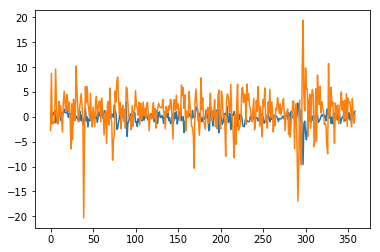

In [104]:
plt.plot(range(len(Factor_sparse[:,0])), Factor_sparse[:,1])
plt.plot(range(en(Factor_sparse[:,0])), Factor[:,0])
plt.show()

In [5]:
variance_ratio= np.zeros((11))
for i in range(1,11):
    variance_ratio[i]= variance[i].real/variance[i+1].real
import matplotlib.pyplot as plt
variance_diff= np.zeros((11))
for i in range(1,11):
    variance_diff[i]= variance[i].real- variance[i+1].real
plt.plot(range(len(variance_ratio)), variance_ratio)
plt.title('Eigenvalue Ratio, PCA, first eliminated')
plt.savefig('C://Users//zihan//Desktop//File//Research//eigratioPCA.png')
plt.clf()
plt.plot(range(len(variance_diff)), variance_diff)
plt.title('Eigenvalue Difference, PCA, first eliminated')
plt.savefig('C://Users//zihan//Desktop//File//Research//eigdiffPCA.png')
plt.clf()

In [23]:
# Get the interpretation of each variable.
import matplotlib.pyplot as plt
print (loading.shape)
chara= 0
count= np.zeros((6))
for chara in range(6):
    for i in range(loading.shape[1]):
        temp= [item[0] for item in nodetag[i]]
        if chara in temp:
            count[chara]+= np.sum(np.abs(loading[:,i]))
objects = ('beme', 'lme', 'lturnover', 'prof', 'momen', 'idio_vol')
y_pos = np.arange(len(objects))
performance = count
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Importance')
plt.savefig('C://Users//zihan//Desktop//Files//Research//importance.png')

(11, 20736)


In [ ]:
def beautiful_print(node):
    
